In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

import logging

In [ ]:
logging.basicConfig(level=logging.DEBUG, filename="model.log",filemode="a",
                    format="%(asctime)s %(levelname)s %(message)s")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
imsize = 512 if torch.cuda.is_available() else 256  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  


def image_loader(image_name): # Отрисовка изображений из тензора
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

content_img = image_loader('YOUR IMAGE')
style_img = image_loader('YOUR IMAGE')



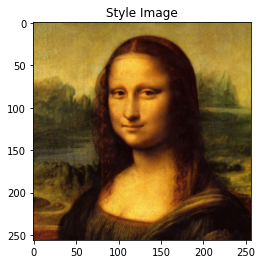

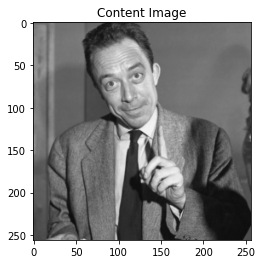

In [ ]:
unloader = transforms.ToPILImage()  

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = F.mse_loss(self.target, self.target) # нужно определить хоть как-то, 
        #поскольку вылезет ошибка при обращении до forward к этому полю

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
# Матрица Грама

def Gram_matrix(input):
  batch_size, h, w, feature_map_num = input.size() # batch_size = 1, (h,w) = dimensions of a feature map
  features = input.view(batch_size * h, w * feature_map_num) # векторизируем карты сверток
  G = torch.mm(features, features.t()) # mm - matrix mul
  return G.div(batch_size * h * w * feature_map_num) # 'normalize'


In [ ]:
class StyleLoss(nn.Module):
      def __init__(self, target_feature):
          super(StyleLoss, self).__init__()
          self.target = Gram_matrix(target_feature).detach()
          self.loss = F.mse_loss(self.target, self.target) # нужно определить хоть как-то, 
          #поскольку вылезет ошибка при обращении до forward к этому полю

      def forward(self, input):
        G = Gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
try:
  cnn = models.vgg19(pretrained=True).features.to(device).eval()
  logging.info("VGG-19 successfully installed")
except:
  logging.warning("There were errors when loading")


Additionally, VGG networks are trained on images with each channel
normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
We will use them to normalize the image before sending it into the network.




In [ ]:
# Параметры нормализации при обучении VGG
cnn_norm_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_norm_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [ ]:
# Конфиг сети VGG-19
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):

    # нормализация
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # списки для лоссов стиля и контента
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            logging.error("Unrecognized layer: {}".format(layer.__class__.__name__), exc_info=True)
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # Обрезаем сеть по последнему слою стиля или контента
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Next, we select the input image. You can use a copy of the content image
or white noise.




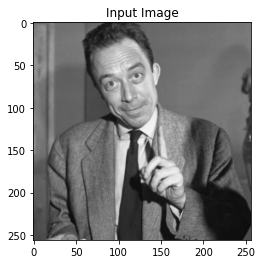

In [ ]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    # Алгоритм Бройдена — Флетчера — Гольдфарба — Шанно
    optimizer = optim.LBFGS([input_img])
    return optimizer

Finally, we must define a function that performs the neural transfer. For
each iteration of the networks, it is fed an updated input and computes
new losses. We will run the ``backward`` methods of each loss module to
dynamicaly compute their gradients. The optimizer requires a “closure”
function, which reevaluates the module and returns the loss.

We still have one final constraint to address. The network may try to
optimize the input with values that exceed the 0 to 1 tensor range for
the image. We can address this by correcting the input values to be
between 0 to 1 each time the network is run.




In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=1000,
                       style_weight=1000000, content_weight=1):

    # Фрейм с картинками, полученными по ходу обучения
    Image_frame = []

    logging.info('Building the style transfer model...')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # Не прокидываем градиенты на модель, только на картинку
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    logging.info('Optimizing..')

    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            print(loss)
            loss.backward()

            run[0] += 1
            if run[0] % 20 == 0:
                logging.info("run {}:".format(run))
                logging.info('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))

                imshow(input_img, title='Output Image')
                Image_frame.append(unloader(input_img.clone().squeeze(0).detach()))

            return style_score + content_score

        optimizer.step(closure)

    # Обрезаем каналы
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img, Image_frame

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

Finally, we can run the algorithm.




<ipython-input-33-bb2df856cd3d>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-33-bb2df856cd3d>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


tensor(3016.0054, grad_fn=<AddBackward0>)
tensor(3013.2463, grad_fn=<AddBackward0>)
tensor(1891.7483, grad_fn=<AddBackward0>)
tensor(1573.5997, grad_fn=<AddBackward0>)
tensor(1249.0782, grad_fn=<AddBackward0>)
tensor(1046.6215, grad_fn=<AddBackward0>)
tensor(935.7327, grad_fn=<AddBackward0>)
tensor(855.9589, grad_fn=<AddBackward0>)
tensor(815.4927, grad_fn=<AddBackward0>)
tensor(739.2675, grad_fn=<AddBackward0>)
tensor(667.1709, grad_fn=<AddBackward0>)
tensor(635.2328, grad_fn=<AddBackward0>)
tensor(600.2227, grad_fn=<AddBackward0>)
tensor(563.0832, grad_fn=<AddBackward0>)
tensor(530.5352, grad_fn=<AddBackward0>)
tensor(519.7242, grad_fn=<AddBackward0>)
tensor(505.4105, grad_fn=<AddBackward0>)
tensor(489.3151, grad_fn=<AddBackward0>)
tensor(475.0451, grad_fn=<AddBackward0>)
tensor(453.7982, grad_fn=<AddBackward0>)


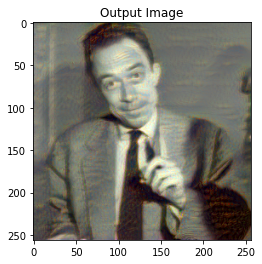

tensor(430.1477, grad_fn=<AddBackward0>)
tensor(412.4769, grad_fn=<AddBackward0>)
tensor(388.1707, grad_fn=<AddBackward0>)
tensor(368.3080, grad_fn=<AddBackward0>)
tensor(412.1928, grad_fn=<AddBackward0>)
tensor(358.5299, grad_fn=<AddBackward0>)
tensor(347.2322, grad_fn=<AddBackward0>)
tensor(335.6536, grad_fn=<AddBackward0>)
tensor(328.1786, grad_fn=<AddBackward0>)
tensor(317.8641, grad_fn=<AddBackward0>)
tensor(308.7166, grad_fn=<AddBackward0>)
tensor(278.0366, grad_fn=<AddBackward0>)
tensor(267.8938, grad_fn=<AddBackward0>)
tensor(263.8437, grad_fn=<AddBackward0>)
tensor(254.3121, grad_fn=<AddBackward0>)
tensor(235.7451, grad_fn=<AddBackward0>)
tensor(225.5535, grad_fn=<AddBackward0>)
tensor(211.0724, grad_fn=<AddBackward0>)
tensor(201.6180, grad_fn=<AddBackward0>)
tensor(192.5007, grad_fn=<AddBackward0>)


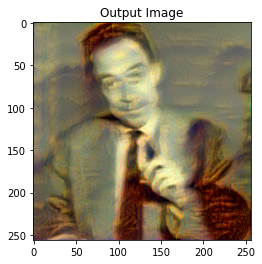

tensor(192.7791, grad_fn=<AddBackward0>)
tensor(183.2733, grad_fn=<AddBackward0>)
tensor(177.7951, grad_fn=<AddBackward0>)
tensor(172.1945, grad_fn=<AddBackward0>)
tensor(160.7623, grad_fn=<AddBackward0>)
tensor(147.0155, grad_fn=<AddBackward0>)
tensor(139.5024, grad_fn=<AddBackward0>)
tensor(130.1418, grad_fn=<AddBackward0>)
tensor(155.9763, grad_fn=<AddBackward0>)
tensor(128.9787, grad_fn=<AddBackward0>)
tensor(120.4095, grad_fn=<AddBackward0>)
tensor(117.9813, grad_fn=<AddBackward0>)
tensor(114.2653, grad_fn=<AddBackward0>)
tensor(109.6464, grad_fn=<AddBackward0>)
tensor(104.8719, grad_fn=<AddBackward0>)
tensor(101.8345, grad_fn=<AddBackward0>)
tensor(94.7105, grad_fn=<AddBackward0>)
tensor(93.4271, grad_fn=<AddBackward0>)
tensor(89.9763, grad_fn=<AddBackward0>)
tensor(87.4891, grad_fn=<AddBackward0>)


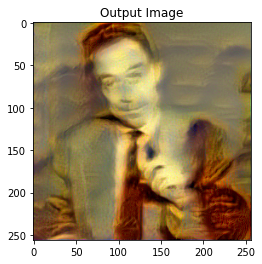

tensor(84.6862, grad_fn=<AddBackward0>)
tensor(82.1113, grad_fn=<AddBackward0>)
tensor(78.1393, grad_fn=<AddBackward0>)
tensor(74.2844, grad_fn=<AddBackward0>)
tensor(70.9653, grad_fn=<AddBackward0>)
tensor(69.6907, grad_fn=<AddBackward0>)
tensor(70.5730, grad_fn=<AddBackward0>)
tensor(65.7559, grad_fn=<AddBackward0>)
tensor(64.0154, grad_fn=<AddBackward0>)
tensor(63.2857, grad_fn=<AddBackward0>)
tensor(61.4661, grad_fn=<AddBackward0>)
tensor(59.9487, grad_fn=<AddBackward0>)
tensor(58.7109, grad_fn=<AddBackward0>)
tensor(56.8466, grad_fn=<AddBackward0>)
tensor(55.7164, grad_fn=<AddBackward0>)
tensor(55.9202, grad_fn=<AddBackward0>)
tensor(54.1436, grad_fn=<AddBackward0>)
tensor(53.5919, grad_fn=<AddBackward0>)
tensor(52.8250, grad_fn=<AddBackward0>)
tensor(50.6570, grad_fn=<AddBackward0>)


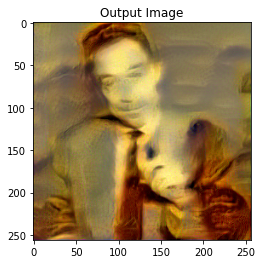

tensor(53.0718, grad_fn=<AddBackward0>)
tensor(49.7983, grad_fn=<AddBackward0>)
tensor(50.1723, grad_fn=<AddBackward0>)
tensor(48.2417, grad_fn=<AddBackward0>)
tensor(47.8796, grad_fn=<AddBackward0>)
tensor(46.8777, grad_fn=<AddBackward0>)
tensor(46.0773, grad_fn=<AddBackward0>)
tensor(45.2927, grad_fn=<AddBackward0>)
tensor(45.0461, grad_fn=<AddBackward0>)
tensor(44.3443, grad_fn=<AddBackward0>)
tensor(43.8233, grad_fn=<AddBackward0>)
tensor(43.4212, grad_fn=<AddBackward0>)
tensor(42.8560, grad_fn=<AddBackward0>)
tensor(42.1446, grad_fn=<AddBackward0>)
tensor(42.1105, grad_fn=<AddBackward0>)
tensor(41.3560, grad_fn=<AddBackward0>)
tensor(40.9868, grad_fn=<AddBackward0>)
tensor(40.5234, grad_fn=<AddBackward0>)
tensor(40.7314, grad_fn=<AddBackward0>)
tensor(39.8226, grad_fn=<AddBackward0>)


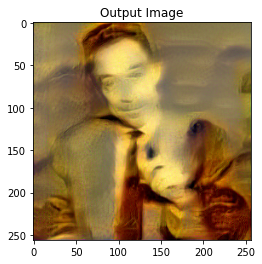

tensor(39.3592, grad_fn=<AddBackward0>)
tensor(38.7912, grad_fn=<AddBackward0>)
tensor(38.3965, grad_fn=<AddBackward0>)
tensor(37.9313, grad_fn=<AddBackward0>)
tensor(37.5661, grad_fn=<AddBackward0>)
tensor(37.0512, grad_fn=<AddBackward0>)
tensor(37.5319, grad_fn=<AddBackward0>)
tensor(36.7591, grad_fn=<AddBackward0>)
tensor(36.1769, grad_fn=<AddBackward0>)
tensor(35.9361, grad_fn=<AddBackward0>)
tensor(35.6618, grad_fn=<AddBackward0>)
tensor(35.3801, grad_fn=<AddBackward0>)
tensor(35.0286, grad_fn=<AddBackward0>)
tensor(34.6270, grad_fn=<AddBackward0>)
tensor(34.4750, grad_fn=<AddBackward0>)
tensor(34.1948, grad_fn=<AddBackward0>)
tensor(33.8669, grad_fn=<AddBackward0>)
tensor(33.6330, grad_fn=<AddBackward0>)
tensor(33.3096, grad_fn=<AddBackward0>)
tensor(33.2240, grad_fn=<AddBackward0>)


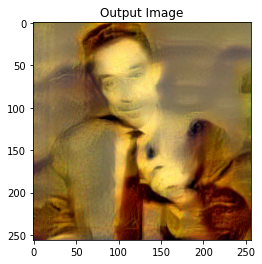

tensor(33.1168, grad_fn=<AddBackward0>)
tensor(32.7943, grad_fn=<AddBackward0>)
tensor(32.5008, grad_fn=<AddBackward0>)
tensor(32.2291, grad_fn=<AddBackward0>)
tensor(32.0324, grad_fn=<AddBackward0>)
tensor(31.6334, grad_fn=<AddBackward0>)
tensor(31.4460, grad_fn=<AddBackward0>)
tensor(31.0522, grad_fn=<AddBackward0>)
tensor(30.9537, grad_fn=<AddBackward0>)
tensor(30.7191, grad_fn=<AddBackward0>)
tensor(30.4476, grad_fn=<AddBackward0>)
tensor(30.1795, grad_fn=<AddBackward0>)
tensor(29.8208, grad_fn=<AddBackward0>)
tensor(29.5349, grad_fn=<AddBackward0>)
tensor(29.3179, grad_fn=<AddBackward0>)
tensor(29.4114, grad_fn=<AddBackward0>)
tensor(29.1887, grad_fn=<AddBackward0>)
tensor(28.7933, grad_fn=<AddBackward0>)
tensor(28.4748, grad_fn=<AddBackward0>)
tensor(28.5012, grad_fn=<AddBackward0>)


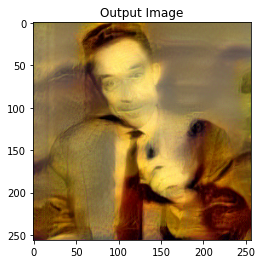

tensor(28.2001, grad_fn=<AddBackward0>)
tensor(27.8855, grad_fn=<AddBackward0>)
tensor(27.7205, grad_fn=<AddBackward0>)
tensor(27.4539, grad_fn=<AddBackward0>)
tensor(27.4524, grad_fn=<AddBackward0>)
tensor(27.2011, grad_fn=<AddBackward0>)
tensor(26.9576, grad_fn=<AddBackward0>)
tensor(26.6682, grad_fn=<AddBackward0>)
tensor(26.6161, grad_fn=<AddBackward0>)
tensor(26.5398, grad_fn=<AddBackward0>)
tensor(26.2324, grad_fn=<AddBackward0>)
tensor(26.0152, grad_fn=<AddBackward0>)
tensor(25.8049, grad_fn=<AddBackward0>)
tensor(25.8068, grad_fn=<AddBackward0>)
tensor(25.7179, grad_fn=<AddBackward0>)
tensor(25.3319, grad_fn=<AddBackward0>)
tensor(25.1290, grad_fn=<AddBackward0>)
tensor(25.0350, grad_fn=<AddBackward0>)
tensor(25.1628, grad_fn=<AddBackward0>)
tensor(25.1474, grad_fn=<AddBackward0>)


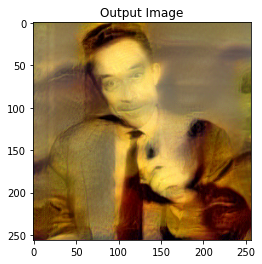

tensor(24.6574, grad_fn=<AddBackward0>)
tensor(24.2099, grad_fn=<AddBackward0>)
tensor(23.9505, grad_fn=<AddBackward0>)
tensor(23.8017, grad_fn=<AddBackward0>)
tensor(23.7118, grad_fn=<AddBackward0>)
tensor(23.7200, grad_fn=<AddBackward0>)
tensor(23.5101, grad_fn=<AddBackward0>)
tensor(23.3121, grad_fn=<AddBackward0>)
tensor(23.0568, grad_fn=<AddBackward0>)
tensor(22.9078, grad_fn=<AddBackward0>)
tensor(22.7493, grad_fn=<AddBackward0>)
tensor(22.6050, grad_fn=<AddBackward0>)
tensor(22.4286, grad_fn=<AddBackward0>)
tensor(22.5432, grad_fn=<AddBackward0>)
tensor(22.1649, grad_fn=<AddBackward0>)
tensor(22.1124, grad_fn=<AddBackward0>)
tensor(22.1935, grad_fn=<AddBackward0>)
tensor(21.7630, grad_fn=<AddBackward0>)
tensor(21.6496, grad_fn=<AddBackward0>)
tensor(21.3526, grad_fn=<AddBackward0>)


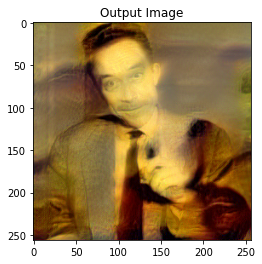

tensor(21.4858, grad_fn=<AddBackward0>)
tensor(21.3810, grad_fn=<AddBackward0>)
tensor(21.2654, grad_fn=<AddBackward0>)
tensor(20.8919, grad_fn=<AddBackward0>)
tensor(20.7635, grad_fn=<AddBackward0>)
tensor(20.8507, grad_fn=<AddBackward0>)
tensor(20.4948, grad_fn=<AddBackward0>)
tensor(20.3664, grad_fn=<AddBackward0>)
tensor(20.1953, grad_fn=<AddBackward0>)
tensor(24.4940, grad_fn=<AddBackward0>)
tensor(27.5897, grad_fn=<AddBackward0>)
tensor(24.5675, grad_fn=<AddBackward0>)
tensor(20.5522, grad_fn=<AddBackward0>)
tensor(19.9412, grad_fn=<AddBackward0>)
tensor(19.7727, grad_fn=<AddBackward0>)
tensor(19.5741, grad_fn=<AddBackward0>)
tensor(19.3936, grad_fn=<AddBackward0>)
tensor(19.2155, grad_fn=<AddBackward0>)
tensor(19.0540, grad_fn=<AddBackward0>)
tensor(18.9774, grad_fn=<AddBackward0>)


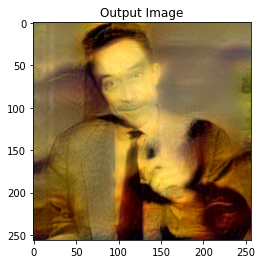

tensor(18.7869, grad_fn=<AddBackward0>)
tensor(18.6645, grad_fn=<AddBackward0>)
tensor(18.4864, grad_fn=<AddBackward0>)
tensor(18.3175, grad_fn=<AddBackward0>)
tensor(18.2420, grad_fn=<AddBackward0>)
tensor(19.0528, grad_fn=<AddBackward0>)
tensor(18.4863, grad_fn=<AddBackward0>)
tensor(18.2136, grad_fn=<AddBackward0>)
tensor(17.9509, grad_fn=<AddBackward0>)
tensor(17.7301, grad_fn=<AddBackward0>)
tensor(17.6328, grad_fn=<AddBackward0>)
tensor(17.5174, grad_fn=<AddBackward0>)
tensor(17.4181, grad_fn=<AddBackward0>)
tensor(18.9073, grad_fn=<AddBackward0>)
tensor(18.5027, grad_fn=<AddBackward0>)
tensor(18.7256, grad_fn=<AddBackward0>)
tensor(17.3089, grad_fn=<AddBackward0>)
tensor(17.1691, grad_fn=<AddBackward0>)
tensor(17.0957, grad_fn=<AddBackward0>)
tensor(16.9190, grad_fn=<AddBackward0>)


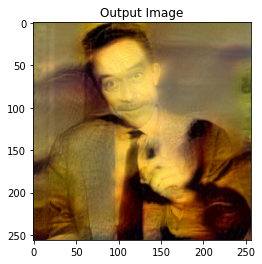

tensor(16.7858, grad_fn=<AddBackward0>)
tensor(16.6486, grad_fn=<AddBackward0>)
tensor(16.5244, grad_fn=<AddBackward0>)
tensor(16.4408, grad_fn=<AddBackward0>)
tensor(18.9306, grad_fn=<AddBackward0>)
tensor(18.6228, grad_fn=<AddBackward0>)
tensor(17.1325, grad_fn=<AddBackward0>)
tensor(16.3295, grad_fn=<AddBackward0>)
tensor(16.1387, grad_fn=<AddBackward0>)
tensor(15.9670, grad_fn=<AddBackward0>)
tensor(15.8561, grad_fn=<AddBackward0>)
tensor(15.7567, grad_fn=<AddBackward0>)
tensor(15.6426, grad_fn=<AddBackward0>)
tensor(15.5658, grad_fn=<AddBackward0>)
tensor(15.4273, grad_fn=<AddBackward0>)
tensor(15.4025, grad_fn=<AddBackward0>)
tensor(15.2613, grad_fn=<AddBackward0>)
tensor(15.1807, grad_fn=<AddBackward0>)
tensor(15.1327, grad_fn=<AddBackward0>)
tensor(19.0879, grad_fn=<AddBackward0>)


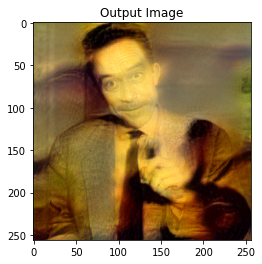

tensor(20.3064, grad_fn=<AddBackward0>)
tensor(17.0196, grad_fn=<AddBackward0>)
tensor(15.6033, grad_fn=<AddBackward0>)
tensor(15.0475, grad_fn=<AddBackward0>)
tensor(14.8861, grad_fn=<AddBackward0>)
tensor(14.7950, grad_fn=<AddBackward0>)
tensor(14.6407, grad_fn=<AddBackward0>)
tensor(14.5496, grad_fn=<AddBackward0>)
tensor(14.4608, grad_fn=<AddBackward0>)
tensor(14.3738, grad_fn=<AddBackward0>)
tensor(14.3014, grad_fn=<AddBackward0>)
tensor(14.3116, grad_fn=<AddBackward0>)
tensor(14.1903, grad_fn=<AddBackward0>)
tensor(14.2372, grad_fn=<AddBackward0>)
tensor(14.0010, grad_fn=<AddBackward0>)
tensor(13.9602, grad_fn=<AddBackward0>)
tensor(13.9066, grad_fn=<AddBackward0>)
tensor(13.8283, grad_fn=<AddBackward0>)
tensor(13.7610, grad_fn=<AddBackward0>)
tensor(14.1114, grad_fn=<AddBackward0>)


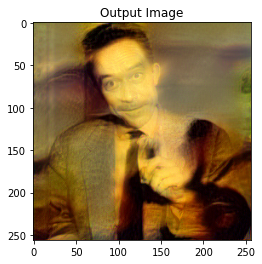

tensor(13.8351, grad_fn=<AddBackward0>)
tensor(13.7576, grad_fn=<AddBackward0>)
tensor(13.6407, grad_fn=<AddBackward0>)
tensor(13.4505, grad_fn=<AddBackward0>)
tensor(13.4177, grad_fn=<AddBackward0>)
tensor(13.3502, grad_fn=<AddBackward0>)
tensor(13.2764, grad_fn=<AddBackward0>)
tensor(13.1863, grad_fn=<AddBackward0>)
tensor(13.3871, grad_fn=<AddBackward0>)
tensor(13.1092, grad_fn=<AddBackward0>)
tensor(13.0751, grad_fn=<AddBackward0>)
tensor(12.9664, grad_fn=<AddBackward0>)
tensor(12.8875, grad_fn=<AddBackward0>)
tensor(12.8500, grad_fn=<AddBackward0>)
tensor(12.7839, grad_fn=<AddBackward0>)
tensor(12.7422, grad_fn=<AddBackward0>)
tensor(12.7524, grad_fn=<AddBackward0>)
tensor(12.7647, grad_fn=<AddBackward0>)
tensor(12.6267, grad_fn=<AddBackward0>)
tensor(12.4888, grad_fn=<AddBackward0>)


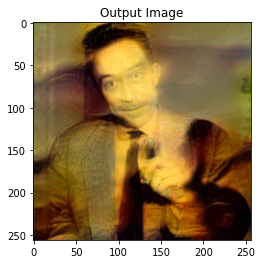

tensor(12.4430, grad_fn=<AddBackward0>)
tensor(12.3949, grad_fn=<AddBackward0>)
tensor(12.3441, grad_fn=<AddBackward0>)
tensor(12.2768, grad_fn=<AddBackward0>)
tensor(12.2383, grad_fn=<AddBackward0>)
tensor(12.1944, grad_fn=<AddBackward0>)
tensor(12.1594, grad_fn=<AddBackward0>)
tensor(12.1415, grad_fn=<AddBackward0>)
tensor(12.1117, grad_fn=<AddBackward0>)
tensor(12.0239, grad_fn=<AddBackward0>)
tensor(12.0697, grad_fn=<AddBackward0>)
tensor(11.8856, grad_fn=<AddBackward0>)
tensor(11.9178, grad_fn=<AddBackward0>)
tensor(11.8119, grad_fn=<AddBackward0>)
tensor(11.7770, grad_fn=<AddBackward0>)
tensor(11.7492, grad_fn=<AddBackward0>)
tensor(11.7846, grad_fn=<AddBackward0>)
tensor(11.7360, grad_fn=<AddBackward0>)
tensor(11.6120, grad_fn=<AddBackward0>)
tensor(11.5727, grad_fn=<AddBackward0>)


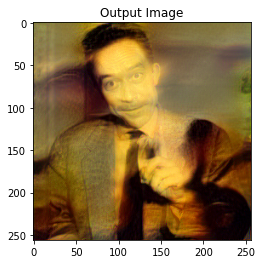

tensor(11.5144, grad_fn=<AddBackward0>)
tensor(11.4658, grad_fn=<AddBackward0>)
tensor(11.4246, grad_fn=<AddBackward0>)
tensor(11.3808, grad_fn=<AddBackward0>)
tensor(11.3384, grad_fn=<AddBackward0>)
tensor(11.3015, grad_fn=<AddBackward0>)
tensor(11.4262, grad_fn=<AddBackward0>)
tensor(11.4123, grad_fn=<AddBackward0>)
tensor(11.2152, grad_fn=<AddBackward0>)
tensor(11.1520, grad_fn=<AddBackward0>)
tensor(11.1297, grad_fn=<AddBackward0>)
tensor(11.0818, grad_fn=<AddBackward0>)
tensor(11.0571, grad_fn=<AddBackward0>)
tensor(11.0546, grad_fn=<AddBackward0>)
tensor(11.0652, grad_fn=<AddBackward0>)
tensor(10.9946, grad_fn=<AddBackward0>)
tensor(10.9002, grad_fn=<AddBackward0>)
tensor(10.8796, grad_fn=<AddBackward0>)
tensor(10.8295, grad_fn=<AddBackward0>)
tensor(10.8056, grad_fn=<AddBackward0>)


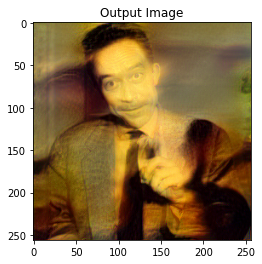

tensor(10.7722, grad_fn=<AddBackward0>)
tensor(10.7321, grad_fn=<AddBackward0>)
tensor(10.6954, grad_fn=<AddBackward0>)
tensor(10.6594, grad_fn=<AddBackward0>)
tensor(10.6261, grad_fn=<AddBackward0>)
tensor(10.5743, grad_fn=<AddBackward0>)
tensor(10.5161, grad_fn=<AddBackward0>)
tensor(10.4849, grad_fn=<AddBackward0>)
tensor(10.4668, grad_fn=<AddBackward0>)
tensor(10.4420, grad_fn=<AddBackward0>)
tensor(10.4043, grad_fn=<AddBackward0>)
tensor(10.3497, grad_fn=<AddBackward0>)
tensor(10.3177, grad_fn=<AddBackward0>)
tensor(10.2900, grad_fn=<AddBackward0>)
tensor(10.3147, grad_fn=<AddBackward0>)
tensor(10.3128, grad_fn=<AddBackward0>)
tensor(10.2046, grad_fn=<AddBackward0>)
tensor(10.1813, grad_fn=<AddBackward0>)
tensor(10.1626, grad_fn=<AddBackward0>)
tensor(10.1357, grad_fn=<AddBackward0>)


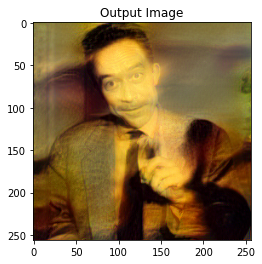

tensor(10.1002, grad_fn=<AddBackward0>)
tensor(10.0803, grad_fn=<AddBackward0>)
tensor(10.0458, grad_fn=<AddBackward0>)
tensor(10.0022, grad_fn=<AddBackward0>)
tensor(9.9783, grad_fn=<AddBackward0>)
tensor(9.9530, grad_fn=<AddBackward0>)
tensor(9.9283, grad_fn=<AddBackward0>)
tensor(9.8740, grad_fn=<AddBackward0>)
tensor(9.8577, grad_fn=<AddBackward0>)
tensor(9.8115, grad_fn=<AddBackward0>)
tensor(9.7913, grad_fn=<AddBackward0>)
tensor(9.7726, grad_fn=<AddBackward0>)
tensor(9.7396, grad_fn=<AddBackward0>)
tensor(9.7095, grad_fn=<AddBackward0>)
tensor(9.6782, grad_fn=<AddBackward0>)
tensor(9.6628, grad_fn=<AddBackward0>)
tensor(9.6793, grad_fn=<AddBackward0>)
tensor(9.6087, grad_fn=<AddBackward0>)
tensor(9.5800, grad_fn=<AddBackward0>)
tensor(9.5522, grad_fn=<AddBackward0>)


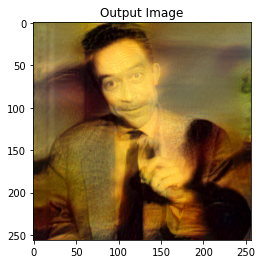

tensor(9.5219, grad_fn=<AddBackward0>)
tensor(9.5130, grad_fn=<AddBackward0>)
tensor(9.4731, grad_fn=<AddBackward0>)
tensor(9.4546, grad_fn=<AddBackward0>)
tensor(9.4339, grad_fn=<AddBackward0>)
tensor(9.4091, grad_fn=<AddBackward0>)
tensor(9.3872, grad_fn=<AddBackward0>)
tensor(9.3679, grad_fn=<AddBackward0>)
tensor(9.3496, grad_fn=<AddBackward0>)
tensor(9.3131, grad_fn=<AddBackward0>)
tensor(9.2658, grad_fn=<AddBackward0>)
tensor(9.2405, grad_fn=<AddBackward0>)
tensor(9.2225, grad_fn=<AddBackward0>)
tensor(9.2168, grad_fn=<AddBackward0>)
tensor(9.1869, grad_fn=<AddBackward0>)
tensor(9.1641, grad_fn=<AddBackward0>)
tensor(9.1388, grad_fn=<AddBackward0>)
tensor(9.1098, grad_fn=<AddBackward0>)
tensor(9.0964, grad_fn=<AddBackward0>)
tensor(9.0787, grad_fn=<AddBackward0>)


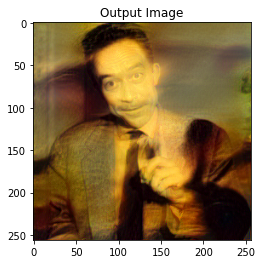

tensor(9.1065, grad_fn=<AddBackward0>)
tensor(9.0812, grad_fn=<AddBackward0>)
tensor(9.0447, grad_fn=<AddBackward0>)
tensor(9.0027, grad_fn=<AddBackward0>)
tensor(8.9918, grad_fn=<AddBackward0>)
tensor(8.9653, grad_fn=<AddBackward0>)
tensor(8.9436, grad_fn=<AddBackward0>)
tensor(8.9191, grad_fn=<AddBackward0>)
tensor(8.8996, grad_fn=<AddBackward0>)
tensor(8.8732, grad_fn=<AddBackward0>)
tensor(8.8594, grad_fn=<AddBackward0>)
tensor(8.8432, grad_fn=<AddBackward0>)
tensor(8.8189, grad_fn=<AddBackward0>)
tensor(8.7802, grad_fn=<AddBackward0>)
tensor(8.7524, grad_fn=<AddBackward0>)
tensor(8.7301, grad_fn=<AddBackward0>)
tensor(8.7206, grad_fn=<AddBackward0>)
tensor(8.7033, grad_fn=<AddBackward0>)
tensor(8.6809, grad_fn=<AddBackward0>)
tensor(8.6480, grad_fn=<AddBackward0>)


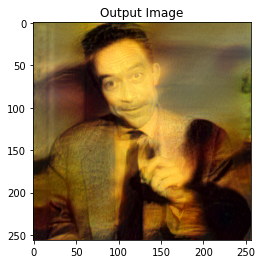

tensor(8.6266, grad_fn=<AddBackward0>)
tensor(8.6082, grad_fn=<AddBackward0>)
tensor(8.5912, grad_fn=<AddBackward0>)
tensor(8.5595, grad_fn=<AddBackward0>)
tensor(8.5323, grad_fn=<AddBackward0>)
tensor(8.5179, grad_fn=<AddBackward0>)
tensor(8.5005, grad_fn=<AddBackward0>)
tensor(8.4759, grad_fn=<AddBackward0>)
tensor(8.4491, grad_fn=<AddBackward0>)
tensor(8.4312, grad_fn=<AddBackward0>)
tensor(8.4177, grad_fn=<AddBackward0>)
tensor(8.3875, grad_fn=<AddBackward0>)
tensor(8.3669, grad_fn=<AddBackward0>)
tensor(8.3506, grad_fn=<AddBackward0>)
tensor(8.3375, grad_fn=<AddBackward0>)
tensor(8.3266, grad_fn=<AddBackward0>)
tensor(8.3124, grad_fn=<AddBackward0>)
tensor(8.2982, grad_fn=<AddBackward0>)
tensor(8.2676, grad_fn=<AddBackward0>)
tensor(8.2480, grad_fn=<AddBackward0>)


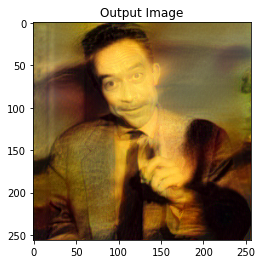

tensor(8.2260, grad_fn=<AddBackward0>)
tensor(8.2174, grad_fn=<AddBackward0>)
tensor(8.2019, grad_fn=<AddBackward0>)
tensor(8.1874, grad_fn=<AddBackward0>)
tensor(8.1643, grad_fn=<AddBackward0>)
tensor(8.1500, grad_fn=<AddBackward0>)
tensor(8.1249, grad_fn=<AddBackward0>)
tensor(8.1005, grad_fn=<AddBackward0>)
tensor(8.0801, grad_fn=<AddBackward0>)
tensor(8.0668, grad_fn=<AddBackward0>)
tensor(8.0534, grad_fn=<AddBackward0>)
tensor(8.0390, grad_fn=<AddBackward0>)
tensor(8.0276, grad_fn=<AddBackward0>)
tensor(8.0064, grad_fn=<AddBackward0>)
tensor(7.9877, grad_fn=<AddBackward0>)
tensor(7.9657, grad_fn=<AddBackward0>)
tensor(7.9525, grad_fn=<AddBackward0>)
tensor(7.9394, grad_fn=<AddBackward0>)
tensor(7.9266, grad_fn=<AddBackward0>)
tensor(7.9043, grad_fn=<AddBackward0>)


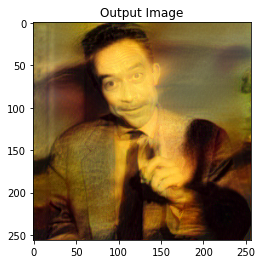

tensor(7.9084, grad_fn=<AddBackward0>)
tensor(7.8879, grad_fn=<AddBackward0>)
tensor(7.8693, grad_fn=<AddBackward0>)
tensor(7.8531, grad_fn=<AddBackward0>)
tensor(7.8440, grad_fn=<AddBackward0>)
tensor(7.8324, grad_fn=<AddBackward0>)
tensor(7.8188, grad_fn=<AddBackward0>)
tensor(7.8096, grad_fn=<AddBackward0>)
tensor(7.7914, grad_fn=<AddBackward0>)
tensor(7.7700, grad_fn=<AddBackward0>)
tensor(7.7543, grad_fn=<AddBackward0>)
tensor(7.7401, grad_fn=<AddBackward0>)
tensor(7.7271, grad_fn=<AddBackward0>)
tensor(7.7118, grad_fn=<AddBackward0>)
tensor(7.6969, grad_fn=<AddBackward0>)
tensor(7.6862, grad_fn=<AddBackward0>)
tensor(7.6788, grad_fn=<AddBackward0>)
tensor(7.6648, grad_fn=<AddBackward0>)
tensor(7.6436, grad_fn=<AddBackward0>)
tensor(7.6283, grad_fn=<AddBackward0>)


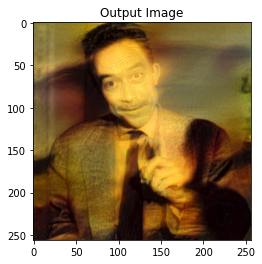

tensor(7.6249, grad_fn=<AddBackward0>)
tensor(7.6117, grad_fn=<AddBackward0>)
tensor(7.6023, grad_fn=<AddBackward0>)
tensor(7.5869, grad_fn=<AddBackward0>)
tensor(7.5717, grad_fn=<AddBackward0>)
tensor(7.5589, grad_fn=<AddBackward0>)
tensor(7.5400, grad_fn=<AddBackward0>)
tensor(7.5238, grad_fn=<AddBackward0>)
tensor(7.5126, grad_fn=<AddBackward0>)
tensor(7.5025, grad_fn=<AddBackward0>)
tensor(7.4886, grad_fn=<AddBackward0>)
tensor(7.4805, grad_fn=<AddBackward0>)
tensor(7.4697, grad_fn=<AddBackward0>)
tensor(7.4556, grad_fn=<AddBackward0>)
tensor(7.4399, grad_fn=<AddBackward0>)
tensor(7.4286, grad_fn=<AddBackward0>)
tensor(7.4178, grad_fn=<AddBackward0>)
tensor(7.4086, grad_fn=<AddBackward0>)
tensor(7.4014, grad_fn=<AddBackward0>)
tensor(7.3909, grad_fn=<AddBackward0>)


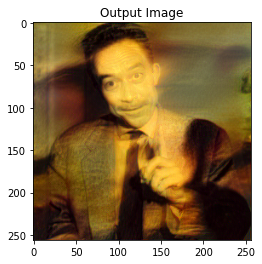

tensor(7.3799, grad_fn=<AddBackward0>)
tensor(7.3694, grad_fn=<AddBackward0>)
tensor(7.3556, grad_fn=<AddBackward0>)
tensor(7.3466, grad_fn=<AddBackward0>)
tensor(7.3344, grad_fn=<AddBackward0>)
tensor(7.3260, grad_fn=<AddBackward0>)
tensor(7.3187, grad_fn=<AddBackward0>)
tensor(7.3103, grad_fn=<AddBackward0>)
tensor(7.2999, grad_fn=<AddBackward0>)
tensor(7.2920, grad_fn=<AddBackward0>)
tensor(7.2793, grad_fn=<AddBackward0>)
tensor(7.2706, grad_fn=<AddBackward0>)
tensor(7.2591, grad_fn=<AddBackward0>)
tensor(7.2490, grad_fn=<AddBackward0>)
tensor(7.2408, grad_fn=<AddBackward0>)
tensor(7.2355, grad_fn=<AddBackward0>)
tensor(7.2290, grad_fn=<AddBackward0>)
tensor(7.2233, grad_fn=<AddBackward0>)
tensor(7.2111, grad_fn=<AddBackward0>)
tensor(7.1999, grad_fn=<AddBackward0>)


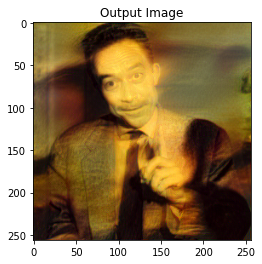

tensor(7.1885, grad_fn=<AddBackward0>)
tensor(7.1800, grad_fn=<AddBackward0>)
tensor(7.1716, grad_fn=<AddBackward0>)
tensor(7.1639, grad_fn=<AddBackward0>)
tensor(7.1605, grad_fn=<AddBackward0>)
tensor(7.1506, grad_fn=<AddBackward0>)
tensor(7.1433, grad_fn=<AddBackward0>)
tensor(7.1339, grad_fn=<AddBackward0>)
tensor(7.1259, grad_fn=<AddBackward0>)
tensor(7.1158, grad_fn=<AddBackward0>)
tensor(7.1055, grad_fn=<AddBackward0>)
tensor(7.0997, grad_fn=<AddBackward0>)
tensor(7.0906, grad_fn=<AddBackward0>)
tensor(7.0849, grad_fn=<AddBackward0>)
tensor(7.0775, grad_fn=<AddBackward0>)
tensor(7.0735, grad_fn=<AddBackward0>)
tensor(7.0665, grad_fn=<AddBackward0>)
tensor(7.0600, grad_fn=<AddBackward0>)
tensor(7.0530, grad_fn=<AddBackward0>)
tensor(7.0453, grad_fn=<AddBackward0>)


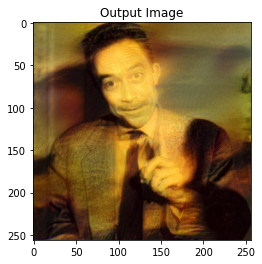

tensor(7.0388, grad_fn=<AddBackward0>)
tensor(7.0314, grad_fn=<AddBackward0>)
tensor(7.0230, grad_fn=<AddBackward0>)
tensor(7.0154, grad_fn=<AddBackward0>)
tensor(7.0102, grad_fn=<AddBackward0>)
tensor(7.0021, grad_fn=<AddBackward0>)
tensor(6.9974, grad_fn=<AddBackward0>)
tensor(6.9903, grad_fn=<AddBackward0>)
tensor(6.9853, grad_fn=<AddBackward0>)
tensor(6.9810, grad_fn=<AddBackward0>)
tensor(6.9740, grad_fn=<AddBackward0>)
tensor(6.9652, grad_fn=<AddBackward0>)
tensor(6.9584, grad_fn=<AddBackward0>)
tensor(6.9524, grad_fn=<AddBackward0>)
tensor(6.9449, grad_fn=<AddBackward0>)
tensor(6.9378, grad_fn=<AddBackward0>)
tensor(6.9331, grad_fn=<AddBackward0>)
tensor(6.9317, grad_fn=<AddBackward0>)
tensor(6.9259, grad_fn=<AddBackward0>)
tensor(6.9227, grad_fn=<AddBackward0>)


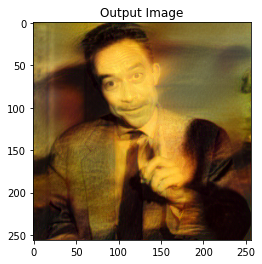

tensor(6.9183, grad_fn=<AddBackward0>)
tensor(6.9114, grad_fn=<AddBackward0>)
tensor(6.9035, grad_fn=<AddBackward0>)
tensor(6.8949, grad_fn=<AddBackward0>)
tensor(6.8899, grad_fn=<AddBackward0>)
tensor(6.8853, grad_fn=<AddBackward0>)
tensor(6.8796, grad_fn=<AddBackward0>)
tensor(6.8729, grad_fn=<AddBackward0>)
tensor(6.8650, grad_fn=<AddBackward0>)
tensor(6.8625, grad_fn=<AddBackward0>)
tensor(6.8588, grad_fn=<AddBackward0>)
tensor(6.8542, grad_fn=<AddBackward0>)
tensor(6.8483, grad_fn=<AddBackward0>)
tensor(6.8422, grad_fn=<AddBackward0>)
tensor(6.8380, grad_fn=<AddBackward0>)
tensor(6.8304, grad_fn=<AddBackward0>)
tensor(6.8242, grad_fn=<AddBackward0>)
tensor(6.8190, grad_fn=<AddBackward0>)
tensor(6.8136, grad_fn=<AddBackward0>)
tensor(6.8076, grad_fn=<AddBackward0>)


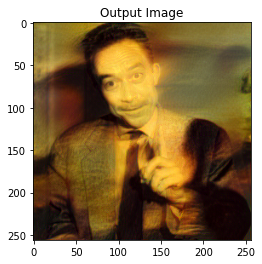

tensor(6.8040, grad_fn=<AddBackward0>)
tensor(6.7982, grad_fn=<AddBackward0>)
tensor(6.7930, grad_fn=<AddBackward0>)
tensor(6.7860, grad_fn=<AddBackward0>)
tensor(6.7800, grad_fn=<AddBackward0>)
tensor(6.7767, grad_fn=<AddBackward0>)
tensor(6.7730, grad_fn=<AddBackward0>)
tensor(6.7716, grad_fn=<AddBackward0>)
tensor(6.7671, grad_fn=<AddBackward0>)
tensor(6.7606, grad_fn=<AddBackward0>)
tensor(6.7547, grad_fn=<AddBackward0>)
tensor(6.7558, grad_fn=<AddBackward0>)
tensor(6.7511, grad_fn=<AddBackward0>)
tensor(6.7461, grad_fn=<AddBackward0>)
tensor(6.7414, grad_fn=<AddBackward0>)
tensor(6.7372, grad_fn=<AddBackward0>)
tensor(6.7329, grad_fn=<AddBackward0>)
tensor(6.7280, grad_fn=<AddBackward0>)
tensor(6.7250, grad_fn=<AddBackward0>)
tensor(6.7200, grad_fn=<AddBackward0>)


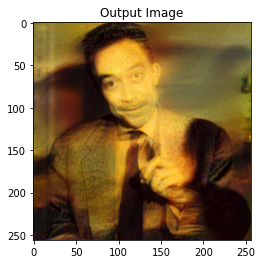

tensor(6.7151, grad_fn=<AddBackward0>)
tensor(6.7108, grad_fn=<AddBackward0>)
tensor(6.7051, grad_fn=<AddBackward0>)
tensor(6.7008, grad_fn=<AddBackward0>)
tensor(6.6966, grad_fn=<AddBackward0>)
tensor(6.6926, grad_fn=<AddBackward0>)
tensor(6.6889, grad_fn=<AddBackward0>)
tensor(6.6871, grad_fn=<AddBackward0>)
tensor(6.6824, grad_fn=<AddBackward0>)
tensor(6.6778, grad_fn=<AddBackward0>)
tensor(6.6737, grad_fn=<AddBackward0>)
tensor(6.6703, grad_fn=<AddBackward0>)
tensor(6.6658, grad_fn=<AddBackward0>)
tensor(6.6630, grad_fn=<AddBackward0>)
tensor(6.6582, grad_fn=<AddBackward0>)
tensor(6.6550, grad_fn=<AddBackward0>)
tensor(6.6514, grad_fn=<AddBackward0>)
tensor(6.6473, grad_fn=<AddBackward0>)
tensor(6.6413, grad_fn=<AddBackward0>)
tensor(6.6376, grad_fn=<AddBackward0>)


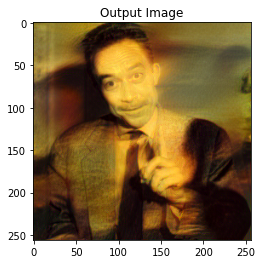

tensor(6.6336, grad_fn=<AddBackward0>)
tensor(6.6276, grad_fn=<AddBackward0>)
tensor(6.6264, grad_fn=<AddBackward0>)
tensor(6.6231, grad_fn=<AddBackward0>)
tensor(6.6195, grad_fn=<AddBackward0>)
tensor(6.6149, grad_fn=<AddBackward0>)
tensor(6.6126, grad_fn=<AddBackward0>)
tensor(6.6084, grad_fn=<AddBackward0>)
tensor(6.6049, grad_fn=<AddBackward0>)
tensor(6.5986, grad_fn=<AddBackward0>)
tensor(6.5959, grad_fn=<AddBackward0>)
tensor(6.5936, grad_fn=<AddBackward0>)
tensor(6.5900, grad_fn=<AddBackward0>)
tensor(6.5857, grad_fn=<AddBackward0>)
tensor(6.5834, grad_fn=<AddBackward0>)
tensor(6.5807, grad_fn=<AddBackward0>)
tensor(6.5769, grad_fn=<AddBackward0>)
tensor(6.5714, grad_fn=<AddBackward0>)
tensor(6.5694, grad_fn=<AddBackward0>)
tensor(6.5664, grad_fn=<AddBackward0>)


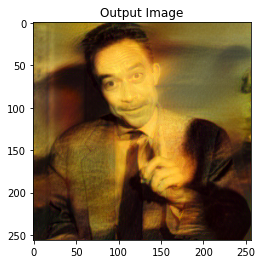

tensor(6.5623, grad_fn=<AddBackward0>)
tensor(6.5576, grad_fn=<AddBackward0>)
tensor(6.5545, grad_fn=<AddBackward0>)
tensor(6.5503, grad_fn=<AddBackward0>)
tensor(6.5473, grad_fn=<AddBackward0>)
tensor(6.5427, grad_fn=<AddBackward0>)
tensor(6.5406, grad_fn=<AddBackward0>)
tensor(6.5368, grad_fn=<AddBackward0>)
tensor(6.5349, grad_fn=<AddBackward0>)
tensor(6.5323, grad_fn=<AddBackward0>)
tensor(6.5307, grad_fn=<AddBackward0>)
tensor(6.5253, grad_fn=<AddBackward0>)
tensor(6.5206, grad_fn=<AddBackward0>)
tensor(6.5182, grad_fn=<AddBackward0>)
tensor(6.5174, grad_fn=<AddBackward0>)
tensor(6.5136, grad_fn=<AddBackward0>)
tensor(6.5092, grad_fn=<AddBackward0>)
tensor(6.5063, grad_fn=<AddBackward0>)
tensor(6.5044, grad_fn=<AddBackward0>)
tensor(6.5027, grad_fn=<AddBackward0>)


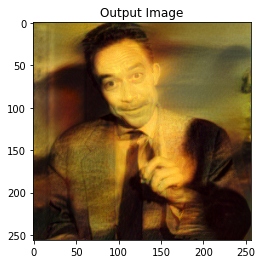

tensor(6.4987, grad_fn=<AddBackward0>)
tensor(6.4953, grad_fn=<AddBackward0>)
tensor(6.4908, grad_fn=<AddBackward0>)
tensor(6.4885, grad_fn=<AddBackward0>)
tensor(6.4872, grad_fn=<AddBackward0>)
tensor(6.4851, grad_fn=<AddBackward0>)
tensor(6.4824, grad_fn=<AddBackward0>)
tensor(6.4794, grad_fn=<AddBackward0>)
tensor(6.4768, grad_fn=<AddBackward0>)
tensor(6.4730, grad_fn=<AddBackward0>)
tensor(6.4710, grad_fn=<AddBackward0>)
tensor(6.4678, grad_fn=<AddBackward0>)
tensor(6.4650, grad_fn=<AddBackward0>)
tensor(6.4624, grad_fn=<AddBackward0>)
tensor(6.4622, grad_fn=<AddBackward0>)
tensor(6.4589, grad_fn=<AddBackward0>)
tensor(6.4561, grad_fn=<AddBackward0>)
tensor(6.4523, grad_fn=<AddBackward0>)
tensor(6.4497, grad_fn=<AddBackward0>)
tensor(6.4486, grad_fn=<AddBackward0>)


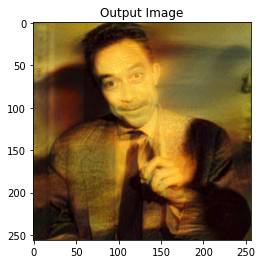

tensor(6.4464, grad_fn=<AddBackward0>)
tensor(6.4433, grad_fn=<AddBackward0>)
tensor(6.4396, grad_fn=<AddBackward0>)
tensor(6.4366, grad_fn=<AddBackward0>)
tensor(6.4334, grad_fn=<AddBackward0>)
tensor(6.4313, grad_fn=<AddBackward0>)
tensor(6.4324, grad_fn=<AddBackward0>)
tensor(6.4289, grad_fn=<AddBackward0>)
tensor(6.4258, grad_fn=<AddBackward0>)
tensor(6.4236, grad_fn=<AddBackward0>)
tensor(6.4214, grad_fn=<AddBackward0>)
tensor(6.4180, grad_fn=<AddBackward0>)
tensor(6.4152, grad_fn=<AddBackward0>)
tensor(6.4142, grad_fn=<AddBackward0>)
tensor(6.4125, grad_fn=<AddBackward0>)
tensor(6.4085, grad_fn=<AddBackward0>)
tensor(6.4053, grad_fn=<AddBackward0>)
tensor(6.4031, grad_fn=<AddBackward0>)
tensor(6.4007, grad_fn=<AddBackward0>)
tensor(6.3988, grad_fn=<AddBackward0>)


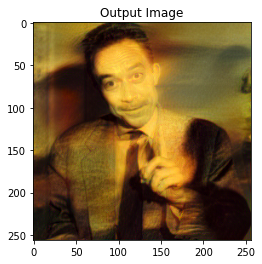

tensor(6.3971, grad_fn=<AddBackward0>)
tensor(6.3938, grad_fn=<AddBackward0>)
tensor(6.3921, grad_fn=<AddBackward0>)
tensor(6.3895, grad_fn=<AddBackward0>)
tensor(6.3879, grad_fn=<AddBackward0>)
tensor(6.3848, grad_fn=<AddBackward0>)
tensor(6.3839, grad_fn=<AddBackward0>)
tensor(6.3811, grad_fn=<AddBackward0>)
tensor(6.3778, grad_fn=<AddBackward0>)
tensor(6.3742, grad_fn=<AddBackward0>)
tensor(6.3722, grad_fn=<AddBackward0>)
tensor(6.3691, grad_fn=<AddBackward0>)
tensor(6.3673, grad_fn=<AddBackward0>)
tensor(6.3652, grad_fn=<AddBackward0>)
tensor(6.3616, grad_fn=<AddBackward0>)
tensor(6.3586, grad_fn=<AddBackward0>)
tensor(6.3560, grad_fn=<AddBackward0>)
tensor(6.3536, grad_fn=<AddBackward0>)
tensor(6.3515, grad_fn=<AddBackward0>)
tensor(6.3484, grad_fn=<AddBackward0>)


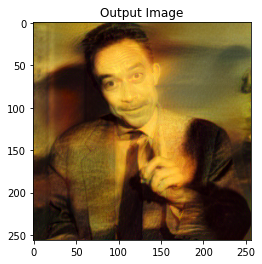

tensor(6.3461, grad_fn=<AddBackward0>)
tensor(6.3450, grad_fn=<AddBackward0>)
tensor(6.3426, grad_fn=<AddBackward0>)
tensor(6.3488, grad_fn=<AddBackward0>)
tensor(6.3440, grad_fn=<AddBackward0>)
tensor(6.3396, grad_fn=<AddBackward0>)
tensor(6.3368, grad_fn=<AddBackward0>)
tensor(6.3356, grad_fn=<AddBackward0>)
tensor(6.3324, grad_fn=<AddBackward0>)
tensor(6.3292, grad_fn=<AddBackward0>)
tensor(6.3263, grad_fn=<AddBackward0>)
tensor(6.3249, grad_fn=<AddBackward0>)
tensor(6.3228, grad_fn=<AddBackward0>)
tensor(6.3200, grad_fn=<AddBackward0>)
tensor(6.3184, grad_fn=<AddBackward0>)
tensor(6.3168, grad_fn=<AddBackward0>)
tensor(6.3155, grad_fn=<AddBackward0>)
tensor(6.3138, grad_fn=<AddBackward0>)
tensor(6.3113, grad_fn=<AddBackward0>)
tensor(6.3084, grad_fn=<AddBackward0>)


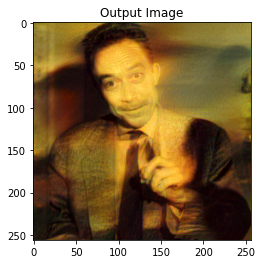

tensor(6.3064, grad_fn=<AddBackward0>)
tensor(6.3050, grad_fn=<AddBackward0>)
tensor(6.3026, grad_fn=<AddBackward0>)
tensor(6.3002, grad_fn=<AddBackward0>)
tensor(6.2989, grad_fn=<AddBackward0>)
tensor(6.2978, grad_fn=<AddBackward0>)
tensor(6.2955, grad_fn=<AddBackward0>)
tensor(6.2924, grad_fn=<AddBackward0>)
tensor(6.2906, grad_fn=<AddBackward0>)
tensor(6.2931, grad_fn=<AddBackward0>)
tensor(6.2894, grad_fn=<AddBackward0>)
tensor(6.2873, grad_fn=<AddBackward0>)
tensor(6.2853, grad_fn=<AddBackward0>)
tensor(6.2828, grad_fn=<AddBackward0>)
tensor(6.2806, grad_fn=<AddBackward0>)
tensor(6.2780, grad_fn=<AddBackward0>)
tensor(6.2761, grad_fn=<AddBackward0>)
tensor(6.2730, grad_fn=<AddBackward0>)
tensor(6.2708, grad_fn=<AddBackward0>)
tensor(6.2686, grad_fn=<AddBackward0>)


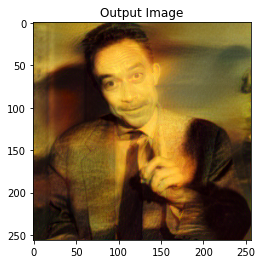

tensor(6.2673, grad_fn=<AddBackward0>)
tensor(6.2656, grad_fn=<AddBackward0>)
tensor(6.2634, grad_fn=<AddBackward0>)
tensor(6.2611, grad_fn=<AddBackward0>)
tensor(6.2600, grad_fn=<AddBackward0>)
tensor(6.2581, grad_fn=<AddBackward0>)
tensor(6.2557, grad_fn=<AddBackward0>)
tensor(6.2524, grad_fn=<AddBackward0>)
tensor(6.2511, grad_fn=<AddBackward0>)
tensor(6.2491, grad_fn=<AddBackward0>)
tensor(6.2528, grad_fn=<AddBackward0>)
tensor(6.2473, grad_fn=<AddBackward0>)
tensor(6.2460, grad_fn=<AddBackward0>)
tensor(6.2444, grad_fn=<AddBackward0>)
tensor(6.2421, grad_fn=<AddBackward0>)
tensor(6.2403, grad_fn=<AddBackward0>)
tensor(6.2379, grad_fn=<AddBackward0>)
tensor(6.2362, grad_fn=<AddBackward0>)
tensor(6.2362, grad_fn=<AddBackward0>)
tensor(6.2362, grad_fn=<AddBackward0>)


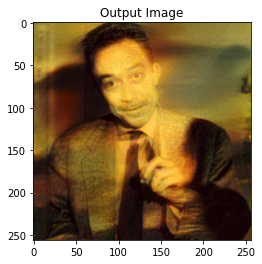

tensor(6.2348, grad_fn=<AddBackward0>)
tensor(6.2308, grad_fn=<AddBackward0>)
tensor(6.2294, grad_fn=<AddBackward0>)
tensor(6.2273, grad_fn=<AddBackward0>)
tensor(6.2255, grad_fn=<AddBackward0>)
tensor(6.2235, grad_fn=<AddBackward0>)
tensor(6.2211, grad_fn=<AddBackward0>)
tensor(6.2192, grad_fn=<AddBackward0>)
tensor(6.2177, grad_fn=<AddBackward0>)
tensor(6.2145, grad_fn=<AddBackward0>)
tensor(6.2123, grad_fn=<AddBackward0>)
tensor(6.2108, grad_fn=<AddBackward0>)
tensor(6.2093, grad_fn=<AddBackward0>)
tensor(6.2110, grad_fn=<AddBackward0>)
tensor(6.2078, grad_fn=<AddBackward0>)
tensor(6.2089, grad_fn=<AddBackward0>)
tensor(6.2033, grad_fn=<AddBackward0>)
tensor(6.2013, grad_fn=<AddBackward0>)
tensor(6.2002, grad_fn=<AddBackward0>)
tensor(6.1989, grad_fn=<AddBackward0>)


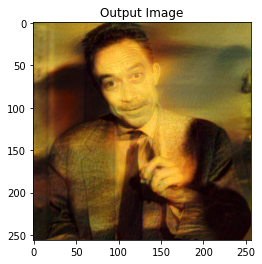

tensor(6.1973, grad_fn=<AddBackward0>)
tensor(6.1942, grad_fn=<AddBackward0>)
tensor(6.1925, grad_fn=<AddBackward0>)
tensor(6.1909, grad_fn=<AddBackward0>)
tensor(6.1889, grad_fn=<AddBackward0>)
tensor(6.1878, grad_fn=<AddBackward0>)
tensor(6.1862, grad_fn=<AddBackward0>)
tensor(6.1849, grad_fn=<AddBackward0>)
tensor(6.1827, grad_fn=<AddBackward0>)
tensor(6.1836, grad_fn=<AddBackward0>)
tensor(6.1816, grad_fn=<AddBackward0>)
tensor(6.1798, grad_fn=<AddBackward0>)
tensor(6.1843, grad_fn=<AddBackward0>)
tensor(6.1809, grad_fn=<AddBackward0>)
tensor(6.1784, grad_fn=<AddBackward0>)
tensor(6.1770, grad_fn=<AddBackward0>)
tensor(6.1753, grad_fn=<AddBackward0>)
tensor(6.1732, grad_fn=<AddBackward0>)
tensor(6.1703, grad_fn=<AddBackward0>)
tensor(6.1682, grad_fn=<AddBackward0>)


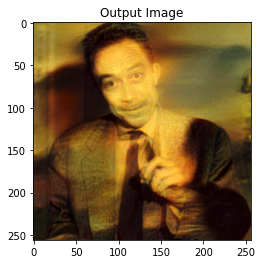

tensor(6.1662, grad_fn=<AddBackward0>)
tensor(6.1645, grad_fn=<AddBackward0>)
tensor(6.1632, grad_fn=<AddBackward0>)
tensor(6.1614, grad_fn=<AddBackward0>)
tensor(6.1612, grad_fn=<AddBackward0>)
tensor(6.1611, grad_fn=<AddBackward0>)
tensor(6.1586, grad_fn=<AddBackward0>)
tensor(6.1559, grad_fn=<AddBackward0>)
tensor(6.1550, grad_fn=<AddBackward0>)
tensor(6.1542, grad_fn=<AddBackward0>)
tensor(6.1540, grad_fn=<AddBackward0>)
tensor(6.1535, grad_fn=<AddBackward0>)
tensor(6.1543, grad_fn=<AddBackward0>)
tensor(6.1493, grad_fn=<AddBackward0>)
tensor(6.1485, grad_fn=<AddBackward0>)
tensor(6.1470, grad_fn=<AddBackward0>)
tensor(6.1456, grad_fn=<AddBackward0>)
tensor(6.1441, grad_fn=<AddBackward0>)
tensor(6.1430, grad_fn=<AddBackward0>)
tensor(6.1417, grad_fn=<AddBackward0>)


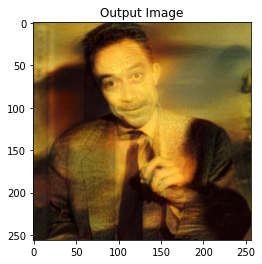

tensor(6.1393, grad_fn=<AddBackward0>)
tensor(6.1376, grad_fn=<AddBackward0>)
tensor(6.1358, grad_fn=<AddBackward0>)
tensor(6.1349, grad_fn=<AddBackward0>)
tensor(6.1337, grad_fn=<AddBackward0>)
tensor(6.1312, grad_fn=<AddBackward0>)
tensor(6.1293, grad_fn=<AddBackward0>)
tensor(6.1281, grad_fn=<AddBackward0>)
tensor(6.1277, grad_fn=<AddBackward0>)
tensor(6.1255, grad_fn=<AddBackward0>)
tensor(6.1272, grad_fn=<AddBackward0>)
tensor(6.1256, grad_fn=<AddBackward0>)
tensor(6.1267, grad_fn=<AddBackward0>)
tensor(6.1233, grad_fn=<AddBackward0>)
tensor(6.1223, grad_fn=<AddBackward0>)
tensor(6.1205, grad_fn=<AddBackward0>)
tensor(6.1183, grad_fn=<AddBackward0>)
tensor(6.1169, grad_fn=<AddBackward0>)
tensor(6.1157, grad_fn=<AddBackward0>)
tensor(6.1142, grad_fn=<AddBackward0>)


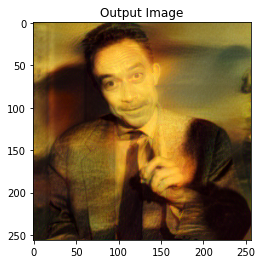

tensor(6.1125, grad_fn=<AddBackward0>)
tensor(6.1105, grad_fn=<AddBackward0>)
tensor(6.1088, grad_fn=<AddBackward0>)
tensor(6.1073, grad_fn=<AddBackward0>)
tensor(6.1062, grad_fn=<AddBackward0>)
tensor(6.1059, grad_fn=<AddBackward0>)
tensor(6.1050, grad_fn=<AddBackward0>)
tensor(6.1032, grad_fn=<AddBackward0>)
tensor(6.1115, grad_fn=<AddBackward0>)
tensor(6.1048, grad_fn=<AddBackward0>)
tensor(6.1015, grad_fn=<AddBackward0>)
tensor(6.0998, grad_fn=<AddBackward0>)
tensor(6.0987, grad_fn=<AddBackward0>)
tensor(6.0969, grad_fn=<AddBackward0>)
tensor(6.0953, grad_fn=<AddBackward0>)
tensor(6.0936, grad_fn=<AddBackward0>)
tensor(6.0918, grad_fn=<AddBackward0>)
tensor(6.0905, grad_fn=<AddBackward0>)
tensor(6.0888, grad_fn=<AddBackward0>)
tensor(6.0885, grad_fn=<AddBackward0>)


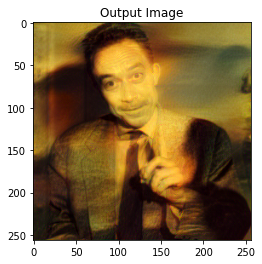

tensor(6.0866, grad_fn=<AddBackward0>)
tensor(6.0852, grad_fn=<AddBackward0>)
tensor(6.0839, grad_fn=<AddBackward0>)
tensor(6.0831, grad_fn=<AddBackward0>)
tensor(6.0823, grad_fn=<AddBackward0>)
tensor(6.0817, grad_fn=<AddBackward0>)
tensor(6.0808, grad_fn=<AddBackward0>)
tensor(6.0806, grad_fn=<AddBackward0>)
tensor(6.0830, grad_fn=<AddBackward0>)
tensor(6.0788, grad_fn=<AddBackward0>)
tensor(6.0778, grad_fn=<AddBackward0>)
tensor(6.0765, grad_fn=<AddBackward0>)
tensor(6.0739, grad_fn=<AddBackward0>)
tensor(6.0744, grad_fn=<AddBackward0>)
tensor(6.0723, grad_fn=<AddBackward0>)
tensor(6.0716, grad_fn=<AddBackward0>)
tensor(6.0704, grad_fn=<AddBackward0>)
tensor(6.0684, grad_fn=<AddBackward0>)
tensor(6.0669, grad_fn=<AddBackward0>)
tensor(6.0654, grad_fn=<AddBackward0>)


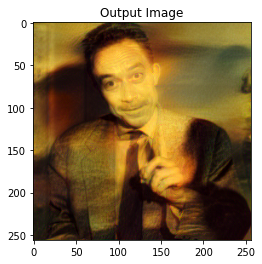

tensor(6.0636, grad_fn=<AddBackward0>)
tensor(6.0621, grad_fn=<AddBackward0>)
tensor(6.0640, grad_fn=<AddBackward0>)
tensor(6.0622, grad_fn=<AddBackward0>)
tensor(6.0606, grad_fn=<AddBackward0>)
tensor(6.0600, grad_fn=<AddBackward0>)
tensor(6.0581, grad_fn=<AddBackward0>)
tensor(6.0569, grad_fn=<AddBackward0>)
tensor(6.0578, grad_fn=<AddBackward0>)
tensor(6.0579, grad_fn=<AddBackward0>)
tensor(6.0553, grad_fn=<AddBackward0>)
tensor(6.0536, grad_fn=<AddBackward0>)
tensor(6.0532, grad_fn=<AddBackward0>)
tensor(6.0522, grad_fn=<AddBackward0>)
tensor(6.0510, grad_fn=<AddBackward0>)
tensor(6.0672, grad_fn=<AddBackward0>)
tensor(6.0633, grad_fn=<AddBackward0>)
tensor(6.0530, grad_fn=<AddBackward0>)
tensor(6.0506, grad_fn=<AddBackward0>)
tensor(6.0492, grad_fn=<AddBackward0>)


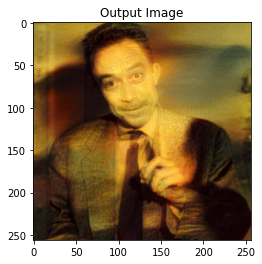

tensor(6.0474, grad_fn=<AddBackward0>)
tensor(6.0452, grad_fn=<AddBackward0>)
tensor(6.0433, grad_fn=<AddBackward0>)
tensor(6.0419, grad_fn=<AddBackward0>)
tensor(6.0409, grad_fn=<AddBackward0>)
tensor(6.0401, grad_fn=<AddBackward0>)
tensor(6.0388, grad_fn=<AddBackward0>)
tensor(6.0371, grad_fn=<AddBackward0>)
tensor(6.0353, grad_fn=<AddBackward0>)
tensor(6.0346, grad_fn=<AddBackward0>)
tensor(6.0336, grad_fn=<AddBackward0>)
tensor(6.0324, grad_fn=<AddBackward0>)
tensor(6.0309, grad_fn=<AddBackward0>)
tensor(6.0373, grad_fn=<AddBackward0>)
tensor(6.0358, grad_fn=<AddBackward0>)
tensor(6.0578, grad_fn=<AddBackward0>)
tensor(6.0441, grad_fn=<AddBackward0>)
tensor(6.0352, grad_fn=<AddBackward0>)
tensor(6.0323, grad_fn=<AddBackward0>)
tensor(6.0312, grad_fn=<AddBackward0>)


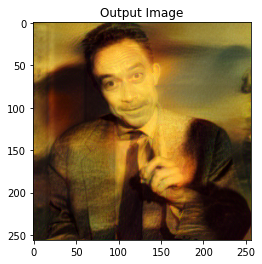

tensor(6.0295, grad_fn=<AddBackward0>)
tensor(6.0281, grad_fn=<AddBackward0>)
tensor(6.0259, grad_fn=<AddBackward0>)
tensor(6.0247, grad_fn=<AddBackward0>)
tensor(6.0234, grad_fn=<AddBackward0>)
tensor(6.0223, grad_fn=<AddBackward0>)
tensor(6.0209, grad_fn=<AddBackward0>)
tensor(6.0193, grad_fn=<AddBackward0>)
tensor(6.0177, grad_fn=<AddBackward0>)
tensor(6.0160, grad_fn=<AddBackward0>)
tensor(6.0149, grad_fn=<AddBackward0>)
tensor(6.0137, grad_fn=<AddBackward0>)
tensor(6.0130, grad_fn=<AddBackward0>)
tensor(6.0122, grad_fn=<AddBackward0>)
tensor(6.0113, grad_fn=<AddBackward0>)
tensor(6.0110, grad_fn=<AddBackward0>)
tensor(6.0149, grad_fn=<AddBackward0>)
tensor(6.0123, grad_fn=<AddBackward0>)
tensor(6.0422, grad_fn=<AddBackward0>)
tensor(6.0189, grad_fn=<AddBackward0>)


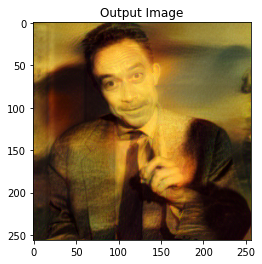

tensor(6.0123, grad_fn=<AddBackward0>)
tensor(6.0099, grad_fn=<AddBackward0>)
tensor(6.0089, grad_fn=<AddBackward0>)
tensor(6.0071, grad_fn=<AddBackward0>)
tensor(6.0058, grad_fn=<AddBackward0>)
tensor(6.0041, grad_fn=<AddBackward0>)
tensor(6.0029, grad_fn=<AddBackward0>)
tensor(6.0019, grad_fn=<AddBackward0>)
tensor(6.0006, grad_fn=<AddBackward0>)
tensor(5.9995, grad_fn=<AddBackward0>)
tensor(5.9981, grad_fn=<AddBackward0>)
tensor(5.9972, grad_fn=<AddBackward0>)
tensor(5.9957, grad_fn=<AddBackward0>)
tensor(5.9948, grad_fn=<AddBackward0>)
tensor(5.9940, grad_fn=<AddBackward0>)
tensor(5.9953, grad_fn=<AddBackward0>)
tensor(5.9929, grad_fn=<AddBackward0>)
tensor(5.9917, grad_fn=<AddBackward0>)
tensor(5.9972, grad_fn=<AddBackward0>)
tensor(5.9933, grad_fn=<AddBackward0>)


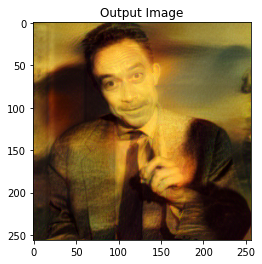

tensor(5.9931, grad_fn=<AddBackward0>)
tensor(5.9912, grad_fn=<AddBackward0>)
tensor(5.9901, grad_fn=<AddBackward0>)
tensor(5.9888, grad_fn=<AddBackward0>)
tensor(5.9871, grad_fn=<AddBackward0>)
tensor(5.9862, grad_fn=<AddBackward0>)
tensor(5.9850, grad_fn=<AddBackward0>)
tensor(5.9839, grad_fn=<AddBackward0>)
tensor(5.9827, grad_fn=<AddBackward0>)
tensor(5.9823, grad_fn=<AddBackward0>)
tensor(5.9823, grad_fn=<AddBackward0>)
tensor(5.9813, grad_fn=<AddBackward0>)
tensor(5.9834, grad_fn=<AddBackward0>)
tensor(5.9803, grad_fn=<AddBackward0>)
tensor(5.9795, grad_fn=<AddBackward0>)
tensor(5.9787, grad_fn=<AddBackward0>)
tensor(5.9776, grad_fn=<AddBackward0>)
tensor(5.9765, grad_fn=<AddBackward0>)
tensor(5.9752, grad_fn=<AddBackward0>)
tensor(5.9750, grad_fn=<AddBackward0>)


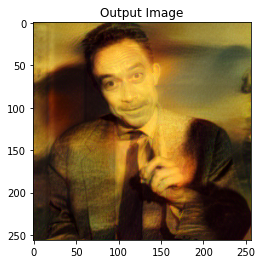

tensor(5.9738, grad_fn=<AddBackward0>)
tensor(5.9733, grad_fn=<AddBackward0>)
tensor(5.9749, grad_fn=<AddBackward0>)
tensor(5.9747, grad_fn=<AddBackward0>)
tensor(5.9726, grad_fn=<AddBackward0>)
tensor(5.9712, grad_fn=<AddBackward0>)
tensor(5.9705, grad_fn=<AddBackward0>)
tensor(5.9687, grad_fn=<AddBackward0>)
tensor(5.9674, grad_fn=<AddBackward0>)
tensor(5.9703, grad_fn=<AddBackward0>)
tensor(5.9682, grad_fn=<AddBackward0>)
tensor(5.9706, grad_fn=<AddBackward0>)
tensor(5.9701, grad_fn=<AddBackward0>)
tensor(5.9656, grad_fn=<AddBackward0>)
tensor(5.9650, grad_fn=<AddBackward0>)
tensor(5.9637, grad_fn=<AddBackward0>)
tensor(5.9623, grad_fn=<AddBackward0>)
tensor(5.9611, grad_fn=<AddBackward0>)
tensor(5.9599, grad_fn=<AddBackward0>)
tensor(5.9585, grad_fn=<AddBackward0>)


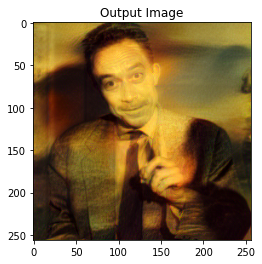

tensor(5.9576, grad_fn=<AddBackward0>)
tensor(5.9602, grad_fn=<AddBackward0>)
tensor(5.9616, grad_fn=<AddBackward0>)
tensor(5.9597, grad_fn=<AddBackward0>)
tensor(5.9611, grad_fn=<AddBackward0>)
tensor(5.9594, grad_fn=<AddBackward0>)
tensor(5.9572, grad_fn=<AddBackward0>)
tensor(5.9560, grad_fn=<AddBackward0>)
tensor(5.9551, grad_fn=<AddBackward0>)
tensor(5.9541, grad_fn=<AddBackward0>)
tensor(5.9530, grad_fn=<AddBackward0>)
tensor(5.9516, grad_fn=<AddBackward0>)
tensor(5.9507, grad_fn=<AddBackward0>)
tensor(5.9493, grad_fn=<AddBackward0>)
tensor(5.9483, grad_fn=<AddBackward0>)
tensor(5.9471, grad_fn=<AddBackward0>)
tensor(5.9459, grad_fn=<AddBackward0>)
tensor(5.9455, grad_fn=<AddBackward0>)
tensor(5.9443, grad_fn=<AddBackward0>)
tensor(5.9436, grad_fn=<AddBackward0>)


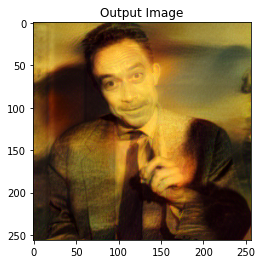

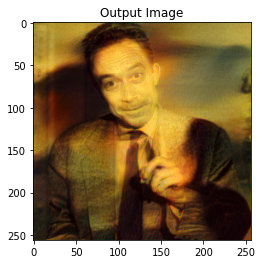

In [ ]:
output, Images = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

In [ ]:
Images[0].save(
    '/content/drive/MyDrive/gif/homer.gif',
    save_all=True,
    append_images=Images[1:],  # Срез который игнорирует первый кадр.
    optimize=True,
    duration=150,
    loop=0
)